From [wrangle report] (https://github.com/wrayz/hw-wrangle-and-analyze-data/blob/master/wrangle_report.html) we wrangling three pieces of information related to the @WeRateDog tweet into a single file. `twitter_archive_master.csv`, the following is my analysis

In [1]:
import pandas as pd
df = pd.read_csv('twitter_archive_master.csv')
df.head(3)

,tweet_id,text,expanded_urls,name,doggo,floofer,pupper,puppo,favorite_count,lang,retweet_count,source,created_at,rating_ratio,breed
0,892177421306343426,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,None,None,None,None,32434,en,6079,iPhone,2017-08-01 00:17:27,1.3,Chihuahua
1,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,None,None,None,None,24430,en,4023,iPhone,2017-07-31 00:18:03,1.2,Chihuahua
2,891689557279858688,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,None,None,None,None,41088,en,8371,iPhone,2017-07-30 15:58:51,1.3,Labrador_retriever


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1663 entries, 0 to 1662
Data columns (total 15 columns):
tweet_id          1663 non-null int64
text              1663 non-null object
expanded_urls     1663 non-null object
name              1663 non-null object
doggo             1663 non-null object
floofer           1663 non-null object
pupper            1663 non-null object
puppo             1663 non-null object
favorite_count    1663 non-null int64
lang              1663 non-null object
retweet_count     1663 non-null int64
source            1663 non-null object
created_at        1663 non-null object
rating_ratio      1663 non-null float64
breed             1663 non-null object
dtypes: float64(1), int64(3), object(11)
memory usage: 195.0+ KB


First of all, I will first list the data levels in the above fields. With these levels, there is a direction to be visualized later:

| Column         | Data Level |
| -------------- | ---------- |
| tweet_id       | Nominal    |
| text           | Nominal    |
| expanded_urls  | Nominal    |
| name           | Nominal    |
| doggo          | Nominal    |
| floofer        | Nominal    |
| pupper         | Nominal    |
| puppo          | Nominal    |
| favorite_count | Discrete   |
| lang           | Nominal    |
| retweet_count  | Discrete   |
| source         | Nominal    |
| created_at     | Continuous |
| rating_ratio   | Ordinal    |
| breed          | Nominal    |

Because this information is @WeRateDog twitter tweet information, including @WeRateDog's rating, dog breed, tweet reposts, and likes...

From this information, I was concerned a question.

> Is @WeRateDog's tweet evaluation the key to popular? 
>
> If not, what is the reason for the tweet to let the public repost or praise?


Looking for this question, I want to start with a simpler question:

Q1. @WeRateDog Which kinds of dogs are often compared?

Q2. Which is the highest score for @WeRateDog?

The highest rating ratio breed is ['Pomeranian']


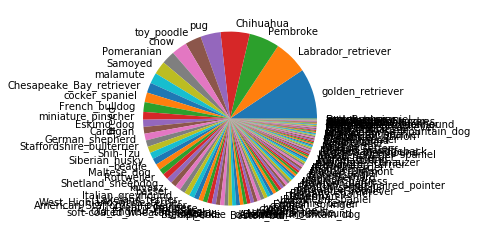

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

print('The highest rating ratio breed is {}'.format(df[df.rating_ratio == df.rating_ratio.max()].breed.values))
df.breed.value_counts().plot(kind='pie')
plt.show()

From the data point of view, we found that @WeRateDog has at least 113 breeds of dogs, and the top four breeds are:

1) Golden retriever 2) Labrador retriever 3) Pembroke 4) Chihuahua

The highest score ever was Pomeranian, and the results were different. Obviously the variety has nothing to do with the score.

However, I can't help but ask: Q3. Does @WeRateDog have a specific range of ratings? Is there a specific pattern?

In [4]:
df.rating_ratio.describe()

count    1663.000000
mean        1.087723
std         0.251692
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max         7.500000
Name: rating_ratio, dtype: float64

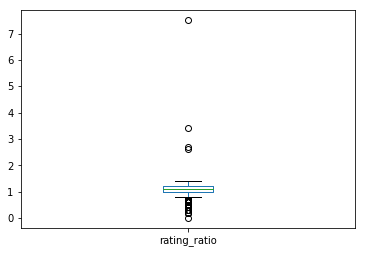

In [5]:
df.rating_ratio.plot.box()
plt.show()

From `describe` showing mean 1.09, std 0.25, the data is quite scattered; the box plot also shows a lot of outliers, so it seems that @WeRateDog is very free to give in the tweet, not a certain range of ratios.

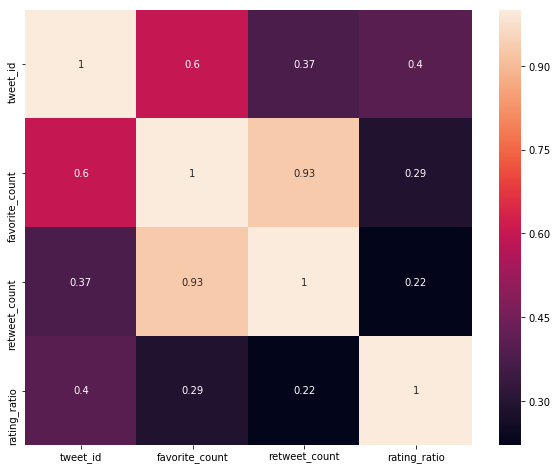

In [6]:
# Use seaborn's heat map to observe linear correlations between characterizations
import seaborn as sns
plt.figure(figsize=(10, 8))
feature_corr = df.corr()
sns.heatmap(feature_corr, annot=True)

_The above field tweet_id,data level is nominal, so this field is ignored first._

Unexpectedly, the heat map shows that @WeRateDog tweet's rating ratio has no strong relationship with favorite count and retweet count.

The highly positive correlation between the favorite count and retweet count is expected.

Here we can learn one thing: @WeRateDog's rating has nothing to do with other people's praises and reposts.

Then the question came. "What is the reason for the tweet to let the public repost or press the praise?"

Looking at the fields, we have two more elements to observe the reasons for the public's praise.
- the stages of dog: doggo, floofer, pupper, puppo
- tweet time: created_at

**_The stage of dog_**

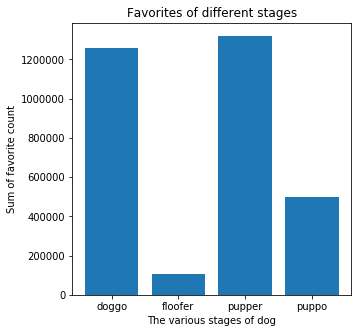

In [7]:
doggo = df.groupby('doggo').favorite_count.sum()[1]
floofer = df.groupby('floofer').favorite_count.sum()[1]
pupper = df.groupby('pupper').favorite_count.sum()[1]
puppo = df.groupby('puppo').favorite_count.sum()[1]

plt.subplots(figsize=(5, 5))
labels = ['doggo','floofer','pupper','puppo']
plt.bar(labels, [doggo,floofer,pupper,puppo])
plt.title('Favorites of different stages')
plt.xlabel('The various stages of dog')
plt.ylabel('Sum of favorite count')
plt.show()

Bar chart "Favorites of different stages" that displays tweets is pupper and doggo, which is generally preferred by everyone.

**_Time_**

Text(0, 0.5, 'Sum of favorite count')

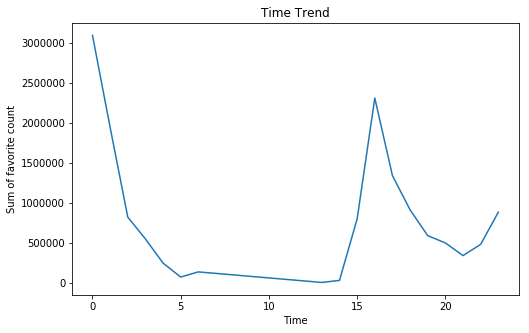

In [9]:
df.created_at = pd.to_datetime(df.created_at)
plt.subplots(figsize=(8, 5))
plt.plot(df.groupby(df.created_at.dt.hour).favorite_count.sum())
plt.title('Time Trend')
plt.xlabel('Time')
plt.ylabel('Sum of favorite count')

The BinGo! Trend chart "Time Trend" shows that there are two periods of time (00:00 - 03:00, 15:00 - 20:00) which are the peak period of the favorite count. It can be seen that the time of the tweet is the key to affecting the public's praise of the @WeRateDog tweet. the reason!

In [10]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'act_report.ipynb'])

0